## Qdrant from Docker container
Based on [official tutorial](https://qdrant.tech/documentation/quickstart/).

```
docker pull qdrant/qdrant

docker run -p 6333:6333 -p 6334:6334 \
    -v $(pwd)/qdrant_storage:/qdrant/storage:z \
    qdrant/qdrant

```



In [ ]:
! pip install ollama langchain qdrant-client pypdf sentence-transformers langchain_ollama langchain-community

In [4]:
from langchain_ollama import OllamaEmbeddings

model_name = 'SpeakLeash/bielik-11b-v2.3-instruct:Q4_K_M'

embeddings = OllamaEmbeddings(
    model=model_name,
)

In [5]:
sample_pl_text = """
Akademia Górniczo-Hutnicza im. Stanisława Staszica w Krakowie 
– polski publiczny uniwersytet techniczny w Krakowie.
Uczelnia została powołana w 1913 r, a jej otwarcie nastąpiło w 1919 r. 
AGH jest uniwersytetem ukierunkowanym na tworzenie innowacyjnych technologii. 
"""

single_vector = embeddings.embed_query(sample_pl_text)

In [6]:
EMBEDING_SIZE = len(single_vector)
print(f"{EMBEDING_SIZE = }")
print(f"{single_vector[:15] = }")

EMBEDING_SIZE = 4096
single_vector[:15] = [0.016410928, 0.017088568, -0.0103728175, 0.011854907, 0.00088668865, -0.031157432, -0.013095488, 0.014185602, -0.0034614613, 0.0117804445, 0.013281992, -0.0034149466, 0.018743351, -0.0043847645, 0.001154755]


In [13]:
from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, Distance

qdrant_client = QdrantClient(url="http://localhost:6333")

collection_name = "documents"

if qdrant_client.collection_exists(collection_name):
    qdrant_client.delete_collection(collection_name)

qdrant_client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(
        size=EMBEDING_SIZE,
        distance=Distance.DOT
    )
)

True

In [7]:
from langchain.document_loaders import PyPDFLoader

def load_pdf(file_path):
    loader = PyPDFLoader(file_path)
    documents = loader.load()
    return documents

In [8]:
sample_file_path = "Wieczna_pamiec_po_galicyjsku_2022-2.pdf"
# https://archiv.ub.uni-heidelberg.de/artdok/8681/1/Nykiel_Beata_Wieczna_pamiec_po_galicyjsku_2022-2.pdf

doc = load_pdf(sample_file_path)

In [9]:
print(len(doc))
doc[5]

19


Document(metadata={'source': 'Wieczna_pamiec_po_galicyjsku_2022-2.pdf', 'page': 5}, page_content='45\nubezpieczeniowy. Po wybuchu wojny, w\xa01915 roku trafił, w\xa0randze kapitana w\xa0stanie spoczyn-\nku (od roku 1906), do krakowskiej komendantury Obrony Krajowej, skąd 1 stycznia 1916 roku \nzostał odkomenderowany jako oficer koncepcyjny do miejscowego kga. Tam, z\xa0czasem jako \nzastępca komendanta służył do zakończenia wojny w\xa01918 roku. O\xa0jego dalszych losach wiadomo \nniewiele. Jako podkomendny Brocha ujawnił swoje uzdolnienia pisarskie. To głównie jemu \nnależy przypisać autorstwo większości cmentarnych inskrypcji na terenie Galicji Zachodniej. \nNiemający precedensu korpus nagrobnych sentencji, którego był autorem, zwraca uwagę za-\nrówno patosem, jak i\xa0walorami literackimi, stanowiąc wciąż niedościgły wzorzec upamiętnienia \nżołnierskiego męstwa i\xa0ofiary. \nW\xa01918 roku Broch i\xa0Hauptmann uwiecznili swoją działalność w\xa0monumentalnej \npublikacji Die westgal

In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

CHUNK_SIZE = 1024
CHUNK_OVERLAP = 128

def split_texts(documents, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    chunks = text_splitter.split_documents(documents)
    return chunks

In [39]:
chunks = split_texts(doc)

In [47]:
chunks[:3]

[Document(metadata={'source': 'Wieczna_pamiec_po_galicyjsku_2022-2.pdf', 'page': 0}, page_content='40\nGENEZA I\xa0KONTEKST GALICYJSKI  \nAUSTRIACKIEGO GROBOWNICTWA \nWOJENNEGO\nSposób, w\xa0jaki traktowano poległych i\xa0zmarłych, od zawsze wpływał na morale wojska i\xa0lud-\nności cywilnej. Zgodnie z\xa0tradycją pochówki szczątków żołnierzy leżały w\xa0gestii armii. Od \nsierpnia 1914 roku do 18 marca 1915, kiedy to austro-węgierska Naczelna Komenda Etapów \n(Etappeoberkommando) wydała rozkaz regulujący kwestie grobownictwa wojennego na ob -\nszarze całej c.k. monarchii, przy Komendach Etapów poszczególnych armii funkcjonowały \nOddziały Uprzątania Pól Bitewnych (Schlachtfelder-Aufrämungs-Abteilungen)1. Zakładanie \nosobnych cmentarzy wojennych traktowano wówczas jako ostateczność, preferowano bowiem \npochówki w\xa0pobliżu obiektów kultu, w\xa0oddzielnych kwaterach na już istniejących cmentarzach. \nOgrom strat w\xa0ludziach, jaki niósł dalszy udział wojsk cesarza Franciszka Józefa 

In [46]:
print(len(chunks))

for i, chunk in enumerate(chunks[:3]):
    print("\n", i, "\n", chunk.page_content)


86

 0 
 40
GENEZA I KONTEKST GALICYJSKI  
AUSTRIACKIEGO GROBOWNICTWA 
WOJENNEGO
Sposób, w jaki traktowano poległych i zmarłych, od zawsze wpływał na morale wojska i lud-
ności cywilnej. Zgodnie z tradycją pochówki szczątków żołnierzy leżały w gestii armii. Od 
sierpnia 1914 roku do 18 marca 1915, kiedy to austro-węgierska Naczelna Komenda Etapów 
(Etappeoberkommando) wydała rozkaz regulujący kwestie grobownictwa wojennego na ob -
szarze całej c.k. monarchii, przy Komendach Etapów poszczególnych armii funkcjonowały 
Oddziały Uprzątania Pól Bitewnych (Schlachtfelder-Aufrämungs-Abteilungen)1. Zakładanie 
osobnych cmentarzy wojennych traktowano wówczas jako ostateczność, preferowano bowiem 
pochówki w pobliżu obiektów kultu, w oddzielnych kwaterach na już istniejących cmentarzach. 
Ogrom strat w ludziach, jaki niósł dalszy udział wojsk cesarza Franciszka Józefa i w Wielkiej 
Wojnie, wymusił jednak koordynację działań grobowniczych na szczeblu centralnym. 3 grudnia

 1 
 Wojnie, wymusił je

In [48]:
for chunk_id, chunk in enumerate(chunks):
    embedding = embeddings.embed_query(chunk.page_content)
    qdrant_client.upsert(
        collection_name=collection_name,
        points=[{
            "id": chunk_id,
            "vector": embedding,
            "payload": {
                "content": chunk.page_content,
                "metadata": chunk.metadata 
            }
        }]
    )

In [27]:
def get_context(query, embeddings=embeddings, qdrant_client=qdrant_client, collection_name="documents", limit=5):
    query_embedding = embeddings.embed_query(query)
    results = qdrant_client.search(
        collection_name=collection_name,
        query_vector=query_embedding,
        limit=limit
    )

    retrieved_contexts = [result.payload["content"] for result in results]
    return retrieved_contexts


Widok kolekcji z panelu Qdrant:

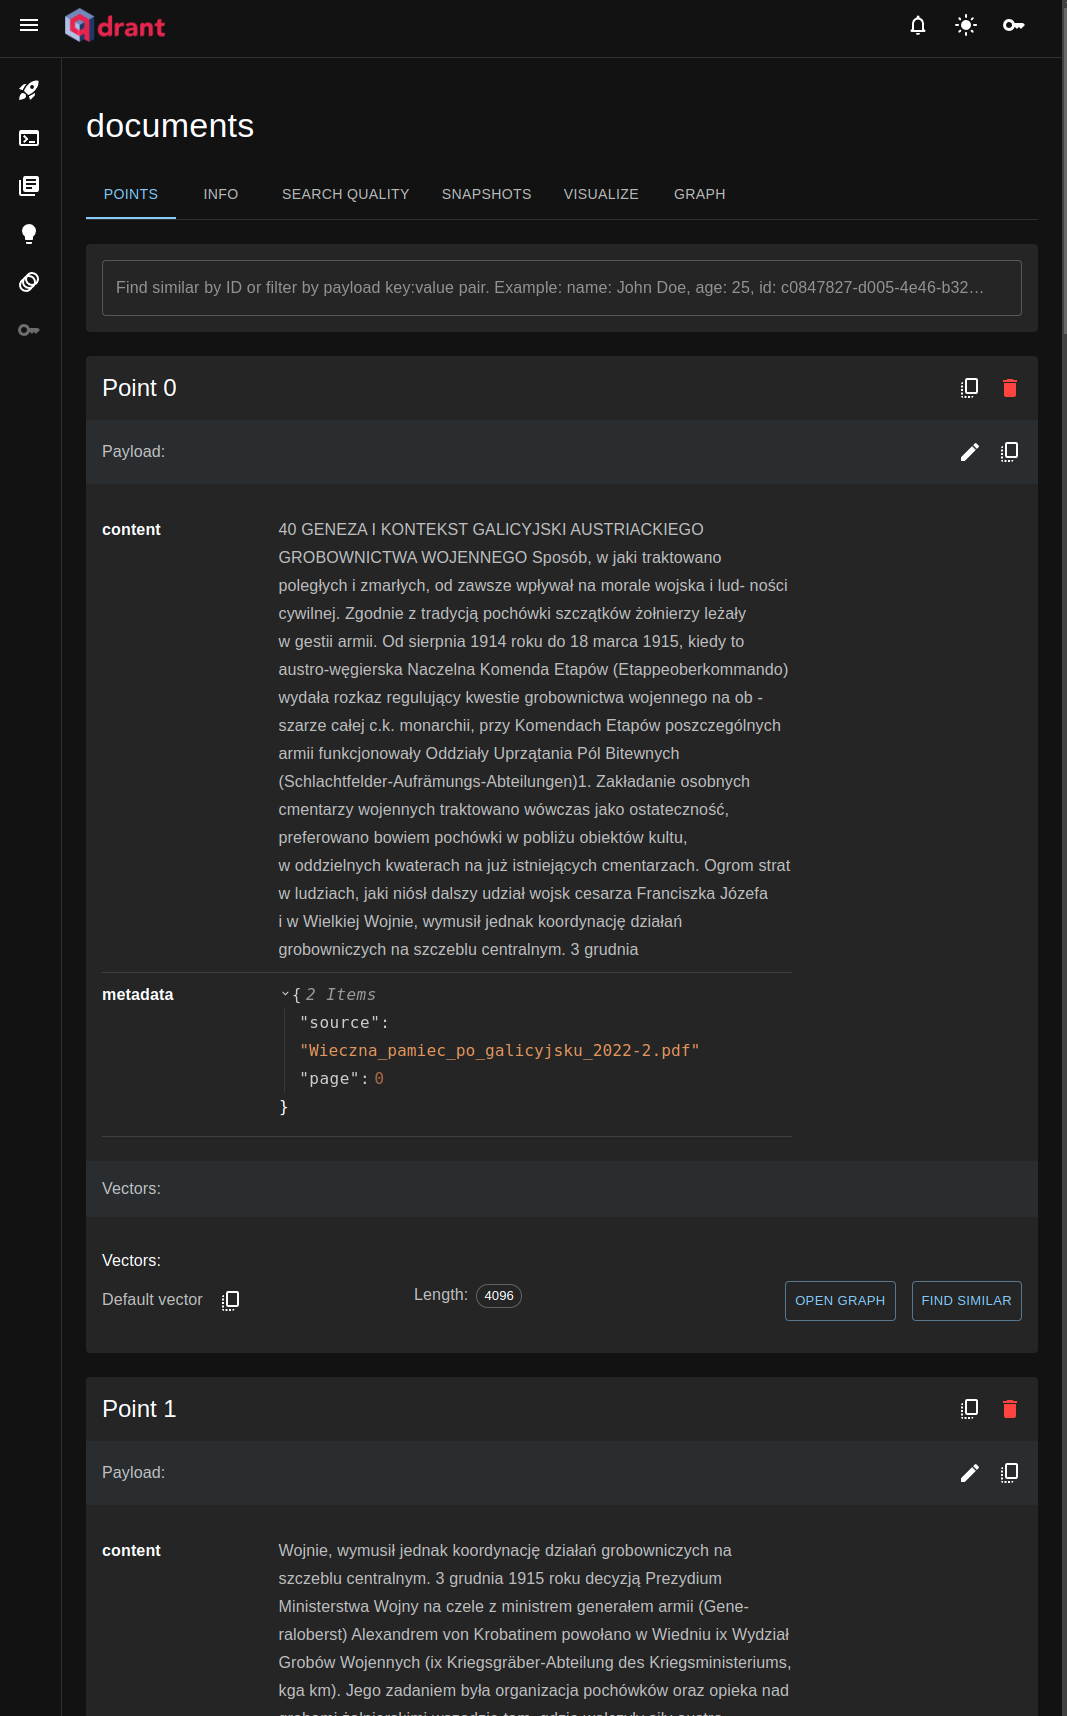


In [37]:
from langchain.prompts import PromptTemplate

prompt_template = PromptTemplate(
    input_variables=["context", "question"],
    template="Kontekst:\n{context}\n\nPytanie:\n{question}\n\nOdpowiedź:"
)

def prepare_prompt(query, template=prompt_template, embeddings=embeddings, qdrant_client=qdrant_client, collection_name="documents", limit=5):
    context_texts = get_context(query, embeddings=embeddings, qdrant_client=qdrant_client, collection_name=collection_name, limit=limit)
    return prompt_template.format(context="\n".join(context_texts), question=query)


In [18]:
sample_question = "Kto odpowiadał za budowę cmentarzy z I wojny światowej w Galicji Zachodniej?"

In [19]:
import ollama

def execute_prompt(prompt):
    response = ollama.chat(model='SpeakLeash/bielik-11b-v2.3-instruct:Q4_K_M', messages=[
    {
        'role': 'user',
        'content': prompt,
    },
    ])

    return response['message']['content']
    

In [83]:
result_no_context = execute_prompt(sample_question)
print(result_no_context)

Budową cmentarzy z I wojny światowej w Galicji Zachodniej zajmowały się głównie oddziały grobownictwa wojennego (Gräberabteilungen) armii austro-węgierskiej. Były to specjalne jednostki, które po zakończeniu działań wojennych zostały utworzone w celu uporządkowania i zorganizowania pochówków żołnierzy poległych na terenie Galicji Zachodniej.

Oddziały te były odpowiedzialne za projektowanie, budowę i utrzymanie cmentarzy wojennych. Współpracowały z lokalnymi władzami oraz społecznościami, aby zapewnić godny pochówek dla poległych żołnierzy różnych narodowości i wyznań.

Warto dodać, że projektowanie cmentarzy często powierzano znanym architektom i artystom, takim jak Hans Mayr, Johann Jäger czy Gustav Rossmann, co przyczyniło się do powstania unikalnych i artystycznie wartościowych miejsc pamięci.


In [84]:
prompt_with_context = prepare_prompt(sample_question, limit=3)
print("PROMPT: \n", prompt_with_context)

result_with_context = execute_prompt(prompt_with_context)
print("\n\nANSWER: \n", result_with_context)

PROMPT: 
 Kontekst: Biura Prasowego (K.u.K. Kriegspressequartier, kpq) generał major Maximilian von Hoen, puł-
kownik niemieckiego sztabu generalnego baron von Hanke, przedstawiciel Honvédu major 
Władysław von Szalay oraz właściciel pobliskich Siar, pionier nafciarstwa i były minister dla 
Galicji Władysław Długosz, który krytykował później rozrzutność władz wojskowych, gdy te 
zgodziły się na nową stałą aranżację tego cmentarza. Mszę polową odprawił superior wojskowy 
ksiądz Józef Kondelewicz w asyście duchownych ewangelickiego, żydowskiego i muzułmań-
skiego, którzy wspólnie odmówili modlitwę za poległych. O oprawę muzyczną i straż honorową 
zadbali oficerowie i żołnierze c.k. 20. pułku piechoty57. Miejsce uroczystości, uwiecznione na 
pocztówkach wydanych nakładem wydawnictwa Polonia przez nauczyciela Adama Wilusza 
w Jarosławiu (1916) i Wilhelma Spiro w Tarnowie (1916 i 1917), szybko stało się główną atrakcją 
wypraw organizowanych na tereny zniszczone podczas walk z maja 1915 rok

In [20]:
questions = [
    {
        "question": "Ilu żołnierzy brało udział w Bitwie pod Gorlicami w 1915 roku?",
        "answer": 
            """ 
            Około 580 tysięcy.
            
            Po zwycięskiej operacji państw centralnych, rozpoczętej w dniach 2–5 maja 1915 roku pod Gorlicami, 
            w której łącznie uczestniczyło dwadzieścia niemieckich i austro-węgierskich dywizji (357,4 tys. żołnierzy)
            oraz siedemnaście dywizji rosyjskich (219 tys. żołnierzy), Galicja Zachodnia znalazła się poza
            teatrem bezpośrednich działań wojennych.
            """
    }, 
    {
        "question": "Ile cmentarzy z I wojny światowej znajduje się w okręgu Bocheńskim (nr. IX)?",
        "answer": 
            """ 
            okręg ix: Bochnia — 46 cmentarzy (numery 299–321, 323–344)
            """
    }, 
    {
        "question": "Co wyróżnia cmentarze znajdujące się w pobliżu Twierdzy Kraków na tle innych cmentarzy z I Wojny Światowej w Galicji Zachodniej",
        "answer": 
            """             
            W przeciwieństwie do pozostałych dziesięciu okręgów poległych w stosunkowo
            nielicznych starciach wokół Krakowa rzadko grzebano w miejscu ich śmierci. Wpływały na to
            zarówno protesty okolicznej ludności, jak i niewielka odległość połączonych 4 lipca 1915 roku
            Krakowa i Podgórza do ich nekropolii. Nad bohaterami starć z listopada i grudnia 1914 roku
            szybko zaczęły dominować ofiary ran i epidemii szerzących się zarówno w licznych krakowskich
            szpitalach wojskowych, jak i w zorganizowanym na terenie koszar 3. Pułku Artylerii Polowej
            (K.u.K. Feldkanonenregiment Nr. 3) obozie jenieckim na Dąbiu.
            """
    }, 
    {
        "question": "Gdzie i w jaki sposób chowano w czasie walk w Galicji w latach 1914-1915 roku żołnierzy pochodzenia żydowskiego?",
        "answer": 
            """             
            Żołnierze wyznania żydowskiego byli chowani na wydzielonych kwaterach cmenta-
            rzy własnych gmin wyznaniowych, na przykład w Krakowie (387), w części nowego cmentarza
            przy ul. Miodowej 55, czy w Bochni, w kwaterze oznaczonej jako cmentarz wojenny 313, okręg ix
            (Bochnia). Na terenie podległym kga dla żołnierzy wyznania mojżeszowego ze wszystkich
            trzech walczących tu armii powstało ich w sumie 15, w tym jeden samodzielny — cudem za-
            chowany, a wybudowany według projektu austriackiego architekta Roberta Motki cmentarz
            w Zakliczynie (293) w okręgu viii (Brzesko)50. 
            """
    }, 
    {
        "question": "Jaką rolę miały pełnić zachodniogalicyjskie cmentarze z I wojny światowej po jej zakończeniu?",
        "answer": 
            """ 
            Miały być miejscem patriotycznych refleksji i kultywowania pamięci o poległych.
            
            Broch i Hauptmann twierdzili: „Po najodle-
            glejsze czasy cmentarze te mają pozostać dla potomnych miejscami katharsis i podniosłych
            refleksji”20. Ich dalekosiężne plany przewidywały dla tego kompleksu doniosłą rolę w pa-
            triotycznej edukacji kolejnych pokoleń c.k. monarchii. Po zakończeniu wojny do opieki nad
            cmentarzami planowano bowiem zatrudnić weteranów wojennych, którzy jako świadkowie
            chwalebnych ofiar współtowarzyszy broni mieli jednocześnie pełnić funkcję przewodników
            po heroicznych kartach najnowszej historii. Ten ostatni pomysł, ze względu na spory kompe-
            tencyjne między władzami wojskowymi a Austriackim Czarnym Krzyżem, którego Broch był
            inicjatorem i pierwszym wiceprezydentem, nie wyszedł jednak poza stadium koncepcyjne
            """
    }, 
    {
        "question": "Co miało charakteryzować krzyże stawiane na grobach żołnierzy rosyjskich pochowanych na terenie galicji zachodniej w czasie I wojny światowej?",
        "answer": 
            """ 
            Motyw liści lipowych i dwie belki.
            
            Ich różnicowanie dotyczyło
            zarówno wykorzystanych materiałów, rodzajów mogił, na których miały się znaleźć, jak i wa-
            riantów odzwierciedlających przynależność do konkretnej armii (motywy liści laurowych
            wskazywały na żołnierzy austro-węgierskich, dębowych — niemieckich, a lipowych — rosyj-
            skich) oraz wyznanie. Początkowo sporo zamieszania wzbudził kształt krzyży stawianych na
            grobach żołnierzy rosyjskich. Ostatecznie po konsultacjach z c.k. duszpasterstwem wojskowym
            Kościoła grecko-orientalnego (prawosławnego) w lutym 1916 roku zdecydowano oznaczać ich
            groby krzyżem dwubelkowym, bez dodatkowej ukośnej belki43.
            """
    }, 
]

In [88]:
LIMIT = 5

for question in questions:
    base_question = question["question"]
    prompt_with_context = prepare_prompt(base_question, limit=LIMIT)
    print("PROMPT: \n", prompt_with_context)
    
    result_with_context = execute_prompt(prompt_with_context)
    print("\n\nANSWER  (WITH CONTEXT): \n", result_with_context)

    result_no_context = execute_prompt(base_question)
    print("\n\nANSWER  (WITHOUT CONTEXT): \n", result_no_context)

    print(15*" --- ")

PROMPT: 
 Kontekst: lokalizacją rosyjsko-austro-
-węgierskich starć w ramach 
tzw. drugiej bitwy o Kraków. 
Zob. Jakub Jamka, Pamiętniki 
bieżanowskiego organisty, red. 
Marta Wójcik-Luksa, Wojciech 
Tokarski, Kraków 2012, [online] 
https:/ /ank.gov.pl/biezanowian/
bitwa.html [dostęp: 3 II 2022]. 
Na temat walk wokół Krakowa 
zob. Henryk Łukasik, Twierdza 
Kraków. Wokół krakowskiej 
twierdzy. Epizody, bohaterowie, 
ślady bitwy o Kraków 1914 r., 
Międzyzdroje 2009, cz. IV,  
s. 43–69.
Kraków 1920, s. 593–624, s. 611 
oraz il. s. 612–614 i 618.
26
 
 Z
ob. R. Broch, H. Hauptmann, 
Zachodniogalicyjskie groby bo-
haterów…, dz. cyt., s. 6, 19, oraz 
między innymi Józef Szymon 
Wroński, Architektura lima-
nowskich cmentarzy z I wojny 
światowej, „Almanach Sądecki” 
1995, nr 1 (10), s. 62–71; ostatnio 
J. Schubert, Cmentarze żoł-
nierskie…, dz. cyt., m.in. s. 222 
oraz il. s. 162, 163, 168, 172, 175, 
180, 185, 203, 205. W ścianę 
kaplicy-mauzoleum cmentarza 
na Jabłońcu (nr 368), okręg X 
(L

## Komentarz
Odpowiedzi udzielane bez dodanego kontekstu są ogólne, czasami zbliżone do prawdy, ale w momencie, w którym modelowi brakuje wiedzy, pojawiają się silne halucynacje - dzieje się tak na przykład przy wymienianiu cmentarzy z okręgu IX - model wymienia tylko 10 z 46, w większości wymieniając nazwy miejscowości, w których rzeczywiście znajdują się cmentarze, ale podawane przez niego numery cmentarzy są całkowicie złe. Podobnie błędne informacje model podaje na temat krzyży stawianych na grobach żołnierzy rosyjskich i na temat pochówków żydowskich. 

Dodając do prompta kontekst, odpowiedzi nie są wcale lepsze - ilość i numeracja cmentarzy w okręgu bocheńskim się zgadza (przynajmniej w pierwszej linijce odpowiedzi), ale w innych przypadkach odpowiedzi nie wypadają wcale wyraźnie lepiej niż w przypadku promptów bez kontekstu - dobierany do zagadnienia kontekst często jest niepoprawny, więc model bazuje na złych informacjach - czasami stara się z nich wyciągnąć jakiekolwiek odpowiadające informacje, a czasami bazuje na "własnej wiedzy". 

Możliwą przyczyną jest niepoprawne zbudowanie bazy wiedzy - tekst źródłowy podzielony na zbyt długie fragmenty lub zastosowana niepoprawna metryka podobieństwa wektorów.

In [14]:
from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, Distance

qdrant_client = QdrantClient(url="http://localhost:6333")

collection_name = "documents_2"

if qdrant_client.collection_exists(collection_name):
    qdrant_client.delete_collection(collection_name)

qdrant_client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(
        size=EMBEDING_SIZE,
        distance=Distance.COSINE # previous Distance.DOT
    )
)

True

In [15]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

CHUNK_SIZE = 512
# 1024 and 128 in previous collection

chunks = split_texts(doc, CHUNK_SIZE, CHUNK_OVERLAP)
chunks[:3]

[Document(metadata={'source': 'Wieczna_pamiec_po_galicyjsku_2022-2.pdf', 'page': 0}, page_content='40\nGENEZA I\xa0KONTEKST GALICYJSKI  \nAUSTRIACKIEGO GROBOWNICTWA \nWOJENNEGO\nSposób, w\xa0jaki traktowano poległych i\xa0zmarłych, od zawsze wpływał na morale wojska i\xa0lud-\nności cywilnej. Zgodnie z\xa0tradycją pochówki szczątków żołnierzy leżały w\xa0gestii armii. Od \nsierpnia 1914 roku do 18 marca 1915, kiedy to austro-węgierska Naczelna Komenda Etapów \n(Etappeoberkommando) wydała rozkaz regulujący kwestie grobownictwa wojennego na ob -\nszarze całej c.k. monarchii, przy Komendach Etapów poszczególnych armii funkcjonowały'),
 Document(metadata={'source': 'Wieczna_pamiec_po_galicyjsku_2022-2.pdf', 'page': 0}, page_content='Oddziały Uprzątania Pól Bitewnych (Schlachtfelder-Aufrämungs-Abteilungen)1. Zakładanie \nosobnych cmentarzy wojennych traktowano wówczas jako ostateczność, preferowano bowiem \npochówki w\xa0pobliżu obiektów kultu, w\xa0oddzielnych kwaterach na już istniejących

In [21]:
for chunk_id, chunk in enumerate(chunks):
    embedding = embeddings.embed_query(chunk.page_content)
    qdrant_client.upsert(
        collection_name=collection_name,
        points=[{
            "id": chunk_id,
            "vector": embedding,
            "payload": {
                "content": chunk.page_content,
                "metadata": chunk.metadata 
            }
        }]
    )

Widok nowej kolekcji panelu Qdrant:

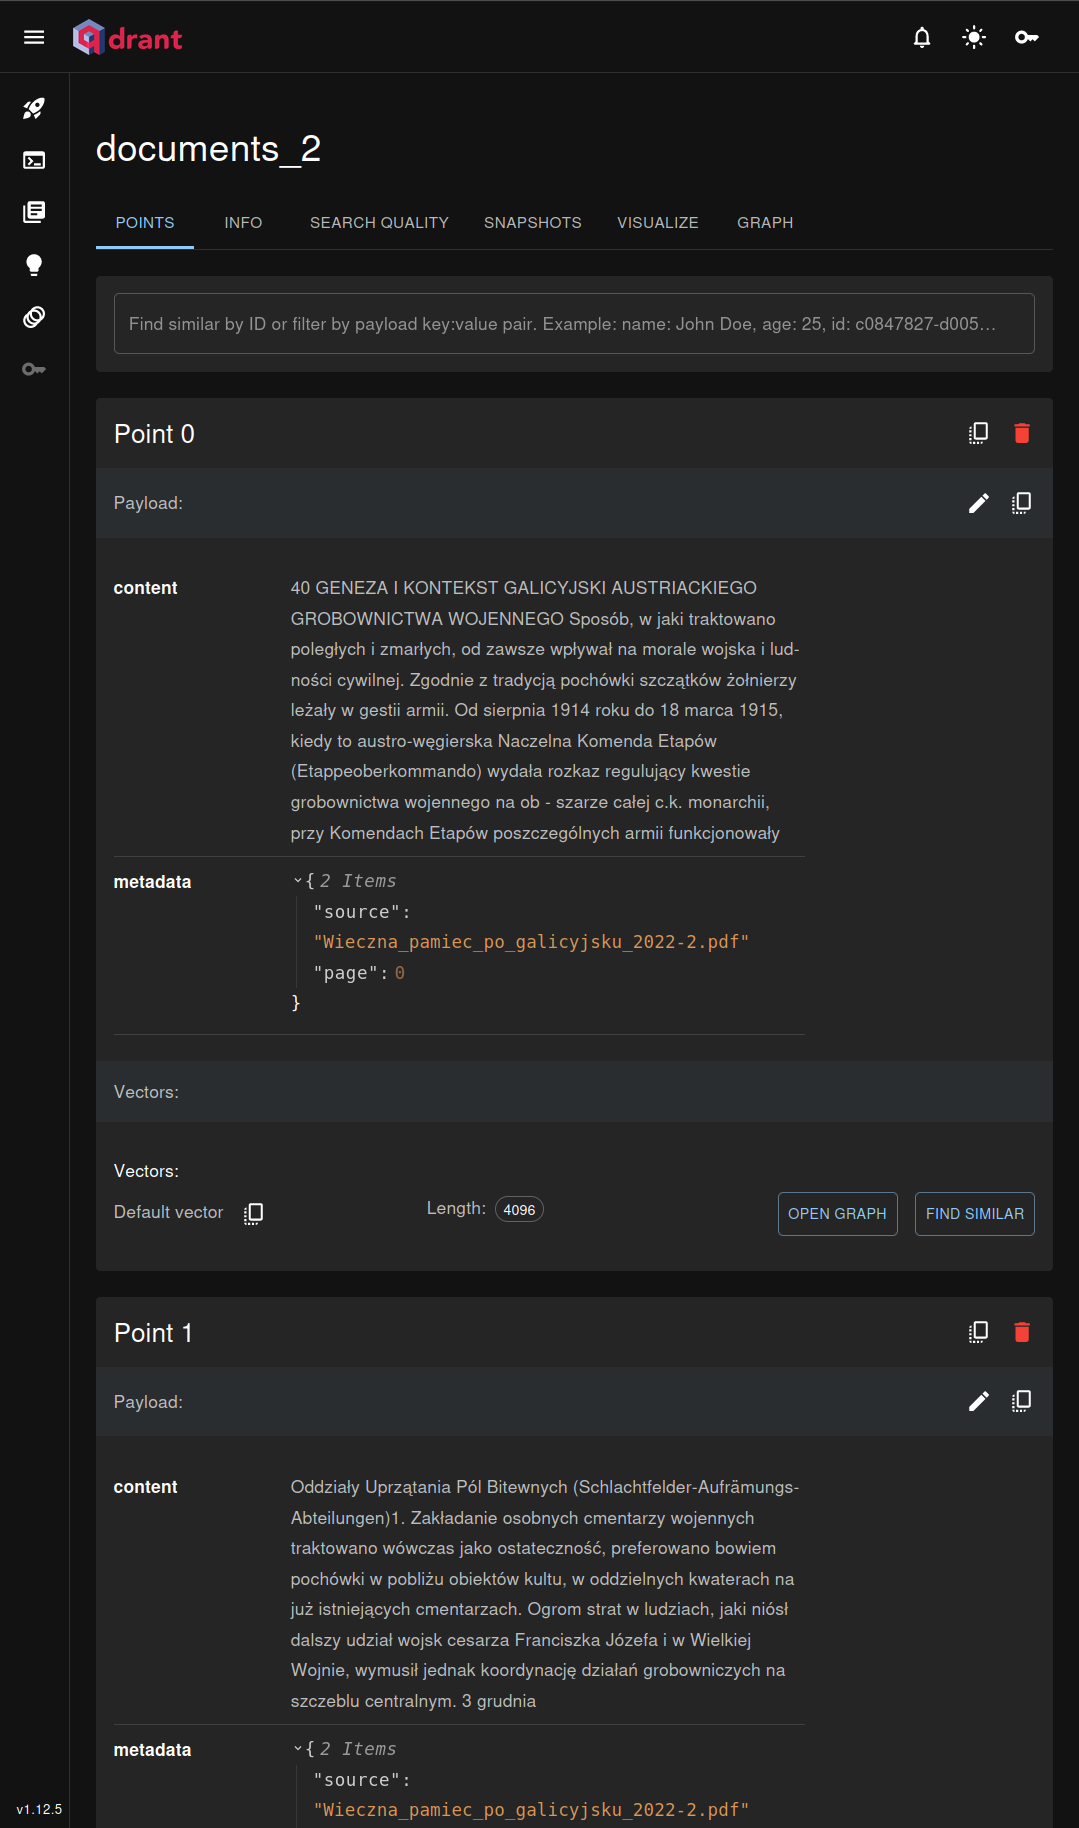


In [32]:
prompt_with_context = prepare_prompt(sample_question, qdrant_client=qdrant_client, collection_name=collection_name, limit=10)
print("PROMPT: \n", prompt_with_context)

result_with_context = execute_prompt(prompt_with_context)
print("\n\nANSWER: \n", result_with_context)

PROMPT: 
 Kontekst:
Dlatego też dziełem podwawelskich „dekowników” były zarówno tamtejsze cmentarze woj -
skowe, jak i cmentarz garnizonowy w Ołomuńcu. Projektantem tego ostatniego był architekt 
kga, morawski Niemiec Gustav Rossmann, autor ponad dwudziestu założeń cmentarnych 
w okręgu v (Pilzno)24. 18 grudnia 1917 roku cmentarz ten został podniesiony do rangi centralnej 
wojskowej nekropolii monarchii przez nowego cesarza Karola I25 (panował od 21 listopada 1916).
na Jabłońcu (nr 368), okręg X 
(Limanowa), wmurowano tablicę 
informującą o wzniesieniu 378 
cmentarzy w latach 1916–1917.
BEATA K. NYKIEL
27   
Jak
o ogólną zasadę w identy-
fikacji cmentarzy przyjęliśmy po-
dawanie w pierwszej kolejności 
nazwy miejscowości, w której 
znajduje się cmentarz, a w na-
wiasie przypisanego cmentarzo-
wi numeru [przyp. red.].
armii, w której regulaminy wojskowe drukowano w trzech językach: niemieckim, węgierskim 
(formacje utworzonego w 1867 roku Honvédu: Królewsko-Węgierskiej Obrony Krajowej) 

In [38]:
LIMIT = 10 #10 shoreter texts instead of 5 longer 

for question in questions:
    base_question = question["question"]
    prompt_with_context = prepare_prompt(base_question, qdrant_client=qdrant_client, collection_name=collection_name, limit=LIMIT)
    print("PROMPT: \n", prompt_with_context)
    
    result_with_context = execute_prompt(prompt_with_context)
    print("\n\nANSWER  (WITH CONTEXT): \n", result_with_context)

    result_no_context = execute_prompt(base_question)
    print("\n\nANSWER  (WITHOUT CONTEXT): \n", result_no_context)

    print(15*" --- " + "\n\n")

PROMPT: 
 Kontekst:
na Jabłońcu (nr 368), okręg X 
(Limanowa), wmurowano tablicę 
informującą o wzniesieniu 378 
cmentarzy w latach 1916–1917.
BEATA K. NYKIEL
27   
Jak
o ogólną zasadę w identy-
fikacji cmentarzy przyjęliśmy po-
dawanie w pierwszej kolejności 
nazwy miejscowości, w której 
znajduje się cmentarz, a w na-
wiasie przypisanego cmentarzo-
wi numeru [przyp. red.].
https:/ /ank.gov.pl/biezanowian/
bitwa.html [dostęp: 3 II 2022]. 
Na temat walk wokół Krakowa 
zob. Henryk Łukasik, Twierdza 
Kraków. Wokół krakowskiej 
twierdzy. Epizody, bohaterowie, 
ślady bitwy o Kraków 1914 r., 
Międzyzdroje 2009, cz. IV,  
s. 43–69.
jej mieszkańców, co bez wątpienia ułatwiło mu realizację powierzonego zadania. Od roku 1909 
był na stałe związany z Krakowem, gdzie pełnił funkcję oficera koncepcyjnego w tutejszym 
dowództwie c.k. Obrony Krajowej (K.u.K. Landwehr), skąd w listopadzie 1915 roku przeszedł, 
jako komendant, do nowo utworzonego kga. Tam pozostał do zakończenia wojny w 1918 roku. 
W 

## Komentarz 

Po zmianie parametrów bazy wiedzy (odległość cosinusowa jako metryka, dwukrotnie mniejsze chunki, ale dwukrotnie więcej chunków dodanych do kontekstu), jakość odpowiedzi modelu nie uległa poprawie. W niektórych pytaniach, na przykład w testowym pytaniu ("Kto odpowiadał za budowę cmentarzy z I wojny światowej w Galicji Zachodniej?") w znalezionym kontekście znalazły się pojedyncze poprawnie dobrane teksty, co pozwoliło modelowi udzielić dość precyzyjnej i w większości poprawnej odpowiedzi. Niestety w innych pytaniach nie wygląda to już tak dobrze - kontekst wciąż nie pomaga w rozwiązaniu zagadnień, model wiele rzeczy "wymyśla" bazując na swojej wiedzy (np. w pytaniu o bitwę pod Gorlicami). 

Halucynacje modelu widać np. w pytaniu o cmentarze w okręgu bocheńskim, w którym wyposażony w kontekst model nie znajduje w bazie fragmentu, który mógłby naprowadzić go na poprawną odpowiedź, a następnie odpowiada:
```
 W okręgu bocheńskim (IX) znajduje się łącznie 14 cmentarzy z I wojny światowej. Oto lista tych cmentarzy wraz z ich numerami i lokalizacjami:

1. Cmentarz nr 328 – Bochnia, ul. Oracka 19
2. Cmentarz nr 329 – Bochnia, ul. Krakowska 67
3. Cmentarz nr 330 – Bochnia, ul. Krakowska 58
4. Cmentarz nr 331 – Bochnia, ul. Krakowska 69
5. Cmentarz nr 332 – Bochnia, ul. Krakowska 71
6. Cmentarz nr 333 – Bochnia, ul. Krakowska 73
7. Cmentarz nr 334 – Bochnia, ul. Krakowska 75
8. Cmentarz nr 335 – Bochnia, ul. Krakowska 77
9. Cmentarz nr 336 – Bochnia, ul. Krakowska 79
10. Cmentarz nr 337 – Bochnia, ul. Krakowska 81
11. Cmentarz nr 338 – Bochnia, ul. Krakowska 83
12. Cmentarz nr 339 – Bochnia, ul. Krakowska 85
13. Cmentarz nr 340 – Bochnia, ul. Krakowska 87
14. Cmentarz nr 341 – Bochnia, ul. Krakowska 89

```
Zła jest liczba cmentarzy (14 zamiast 46) ich położenie i numeracja (w samej Bochni znajdują się dwa cmentarze z I WŚ, z czego jeden rzeczywiście jest fragmentem cmentarza komunalnego znajdującego się na ulicy Orackiej)


Całkowicie zła odpowiedź jest również udzielona przez model z kontekstem na pytanie o krzyże na grobach żołnierzy rosyjskich:

```
Krzyże stawiane na grobach żołnierzy rosyjskich pochowanych na terenie Galicji Zachodniej w czasie I wojny światowej miały charakteryzować się prostotą i skromnością. Zgodnie z ówczesnymi zwyczajami, groby żołnierzy nieprzyjacielskich były zazwyczaj oznaczane prostymi drewnianymi krzyżami lub metalowymi tabliczkami. W przypadku żołnierzy rosyjskich, którzy byli prawosławnymi, stawiano krzyże w formie charakterystycznej dla tej religii – z trzema poprzecznymi ramionami. Krzyże te były często wykonane z drewna lub metalu i miały skromny wygląd, bez ozdobnych elementów czy inskrypcji. Celem takiego podejścia było oddanie szacunku poległym żołnierzom, ale jednocześnie uniknięcie nadmiernego upamiętniania ich wrogiej obecności na terenie Galicji Zachodniej.
```
W rzeczywistości było dokładnie odwrotnie - w czasie I WŚ na terenie Galicji Zachodniej poległych wrogów traktowano niemal z takim samym szacunkiem jak własnych żołnierzy - krzyże, w tym na grobach rosjan były metalowe i często bogato zdobione. Dodatkowo nie miały trzech belek, ale dwie - zrezygnowano z trzeciej ukośnej belki charakterystycznej dla prawosławia (możliwe, że było to spowodowane tym, że w armii rosyjskiej służyło również wielu żołnierzy innych wyznań, np. Polacy z zaboru rosyjskiego, ale akurat tego użyty w zadaniu pdf nie wyjaśnia).

W innych pytaniach również występuje problem z prawidłowym dobraniem kontekstu przez co odpowiedzi modelu wcale nie są lepsze od odpowiedzi udzielanych na to samo pytanie przez model, któremu nie dostarczono kontekstu.

**Bielik wraz z prostym RAGiem wykorzystującym wiedzę z tylko jednego, kilkunastostronnicowego pliku pdf nie radzi sobie zbyt dobrze z zagadnieniem Zachodniogalicyjskich cmentarzy z I WŚ.**

Możliwe, że sytuację poprawiłoby dodanie większej liczby dokumentów dotyczących tego tematu - w obecnej formie nie widać niestety wyraźnej przewagi modelu, który wykorzystuje dodatkowy kontekst nad takim, który nie używa dodatkowych informacji. Po usprawnieniu rozwiązania, tak, aby znajdowany kontekst był bardziej adekwatny, możliwe byłyby dalsze ekspemennty z treścią samego promptu i użcie na przykład schematu:

```
prompt_template = PromptTemplate(
    input_variables=["context", "question"],
    template="{question} - odpowiedz na pytanie bazując na następujących wiadomościach: \n{context}:"
)
```
Poprawę działania stworzeonego systemu mogłoby również przynieść użycie bardziej rozbudowanego niż Bielik modelu w przetwarzaniu takiego prompta.
Jednak to nie konstukcja prompta ani użyty do jego przetworzenia model, ale odpowiednia ekstrakcja wiadomości z dokumentu, okazała się być największym wzwaniem.

Źródłem problemów może być użycie Bielika do tworzenia osadzeń tekstów. Stworzone wektory mają rozmiar 4096, co może utrudniać przeszukiwanie bazy i znajdowanie użytecznych tekstów (niezależnie od wybranej długości i stosowanej metryki). Sytuację mogłoby poprawić na przykład użycie w tym celu prostszego modelu (np. intfloat/multilingual-e5-large używanego w labolatorium 8, który tworzy embedingi o długości 1024 elementów).

Zastosowanie bazy danych Qdrant, która może być łatwo integorowana z pakietem langchain ułatwiło pracę nad zadaniem i umożliwiło efektywne przeszukiwanie zbioru danych. W przypadku jednego dokumentu (maksymalnie 161 pnktów w bazie), wpływ bazy na wydajność nie był zbyt duży. Gdyby użytych dokumentów było znacznie więcej, Qdrant miałby większą przewagę nad innymi (nie stworzonymi w tym celu) rozwiązaniami.



Dla porównania, odpowiedzi udzielone na pytania przez model GPT-4o (bez kontekstu) wydają się być na podobnym lub tylko nieco wyższym poziomie niż odpowiedzi udzielane przez Bielika (bez kontekstu)

Prompt:
```
Krótko odpowiedz na pytania:
Ilu żołnierzy brało udział w Bitwie pod Gorlicami w 1915 roku?
Ile cmentarzy z I wojny światowej znajduje się w okręgu Bocheńskim (nr. IX)?
Co wyróżnia cmentarze znajdujące się w pobliżu Twierdzy Kraków na tle innych cmentarzy z I Wojny Światowej w Galicji Zachodniej
Gdzie i w jaki sposób chowano w czasie walk w Galicji w latach 1914-1915 roku żołnierzy pochodzenia żydowskiego?
Jaką rolę miały pełnić zachodniogalicyjskie cmentarze z I wojny światowej po jej zakończeniu?
Co miało charakteryzować krzyże stawiane na grobach żołnierzy rosyjskich pochowanych na terenie galicji zachodniej w czasie I wojny światowej?
```

Odpowiedź:
```
Ilu żołnierzy brało udział w Bitwie pod Gorlicami w 1915 roku?
Około 300 tysięcy żołnierzy po stronie państw centralnych oraz około 200 tysięcy po stronie rosyjskiej.

Ile cmentarzy z I wojny światowej znajduje się w okręgu Bocheńskim (nr. IX)?
W okręgu Bocheńskim znajduje się 40 cmentarzy wojennych.

Co wyróżnia cmentarze znajdujące się w pobliżu Twierdzy Kraków na tle innych cmentarzy z I Wojny Światowej w Galicji Zachodniej?
Cmentarze te cechuje połączenie funkcji wojskowych i obronnych z miejscem pamięci oraz wykorzystanie elementów architektury Twierdzy Kraków w ich konstrukcji.

Gdzie i w jaki sposób chowano w czasie walk w Galicji w latach 1914-1915 roku żołnierzy pochodzenia żydowskiego?
Żołnierzy żydowskich chowano na wyodrębnionych kwaterach w obrębie cmentarzy wojennych, z zachowaniem zasad żydowskiego obrządku pogrzebowego.

Jaką rolę miały pełnić zachodniogalicyjskie cmentarze z I wojny światowej po jej zakończeniu?
Miały być trwałymi miejscami pamięci i świadectwem godności, z jaką pochowano żołnierzy wszystkich narodowości, niezależnie od strony konfliktu.

Co miało charakteryzować krzyże stawiane na grobach żołnierzy rosyjskich pochowanych na terenie Galicji Zachodniej w czasie I wojny światowej?
Krzyże były wzorowane na krzyżach prawosławnych, uwzględniając tradycje religijne żołnierzy rosyjskich.
```

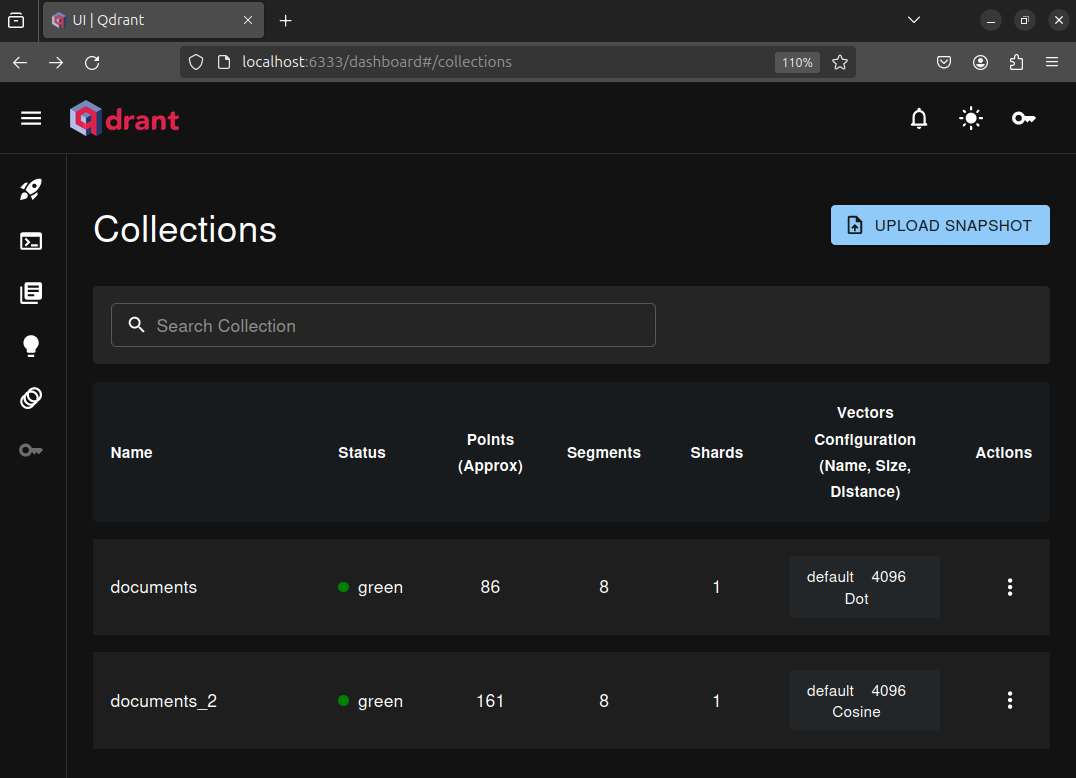
